## Aprendizaje Automático Supervisado

## 3º GrIA, USC

# Práctica 3: Redes Neuronales (Parte I)

Este fichero Notebook contiene la solución del siguiente equipo al guion de prácticas proporcionado en el Aula Virtual de la asignatura.

Miembros del equipo:
- _Estudiante1_: Nombre, Apellidos
- _Estudiante2_: Nombre, Apellidos
- _Estudiante3_: Nombre, Apellidos

# 0. Instalación de Paquetes

Escribe en la siguiente celda de código las instrucciones necesarias para cargar los paquetes de Python que necesitéis

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, LeaveOneOut, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, cohen_kappa_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
# Completa con los imports necesarios
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

Además, para garantizar la reproducibilidad de resultados vamos a fijar una semilla que se use con todos los algoritmos que tengan alguna componente no determinista (**no cambies el código de la siguiente celda**).

In [2]:
# Definir semilla
SEMILLA = 1492
np.random.seed(SEMILLA)

# 1. Estudio guiado

Escribe en las siguientes celdas de código las instrucciones necesarias para cargar los conjuntos de datos (ficheros csv) proporcionados en el Aula Virtual. Para el análisis de los datos podéis añadir las celdas que necesitéis.

### a.	Carga de datos

> Cargad el conjunto de datos de entrenamiento (breast-cancer-train.csv) y realizad una inspección/visualización inicial del mismo. Podéis aplicar el mismo pre-procesamiento realizado en las prácticas anteriores a fin de tratar los missing values

In [6]:
dataset = pd.read_csv("breast-cancer-train.csv")
test = pd.read_csv("breast-cancer-test.csv")

In [4]:
dataset.drop(columns=["id"], inplace=True)
dataset.drop_duplicates(inplace=True)
X = dataset.drop(columns=["diagnosis"])
y = dataset["diagnosis"].map({"M": 1, "B": 0})

imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

In [7]:
test.drop(columns=["id"], inplace=True)
test.drop_duplicates(inplace=True)
X_test = test.drop(columns=["diagnosis"])
y_test = test["diagnosis"].map({"M": 1, "B": 0})

X_imputed_test = imputer.transform(X_test)

### b. Escalado de datos

> Para  sacar  el  máximo  rendimiento  a  las  redes  neuronales  artificiales,  necesitamos  escalar  los  datos. Probad las siguientes opciones: MinMaxScaler, StandardScaler, RobustScaler, y Normalización logarítmica, para la cual podéis usar funciones  lamda: 

~~~python
dt_train_log_X[i] = dt_train_red_X[i].apply(lambda x: np.log(x) if x != 0 else 0) 
~~~

In [12]:
# --- MinMaxScaler ---
# Escala los datos a un rango fijo, generalmente [0, 1].
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_imputed)
X_test_minmax = min_max_scaler.transform(X_imputed_test)
# Convertir de nuevo a DataFrame para mantener los nombres de las columnas
X_train_minmax = pd.DataFrame(X_train_minmax, columns=X.columns)
X_test_minmax = pd.DataFrame(X_test_minmax, columns=X.columns)

# --- StandardScaler ---
# Transforma los datos para que tengan media 0 y desviación estándar 1.
standard_scaler = StandardScaler()
X_train_std = standard_scaler.fit_transform(X_imputed)
X_test_std = standard_scaler.transform(X_imputed_test)
X_train_std = pd.DataFrame(X_train_std, columns=X.columns)
X_test_std = pd.DataFrame(X_test_std, columns=X.columns)

# --- RobustScaler ---
# Similar a StandardScaler, pero usa la mediana y los cuantiles, haciéndolo robusto a outliers.
robust_scaler = RobustScaler()
X_train_robust = robust_scaler.fit_transform(X_imputed)
X_test_robust = robust_scaler.transform(X_imputed_test)
X_train_robust = pd.DataFrame(X_train_robust, columns=X.columns)
X_test_robust = pd.DataFrame(X_test_robust, columns=X.columns)

# --- Normalización Logarítmica ---
# Aplica el logaritmo a los datos. Es útil para datos con distribuciones sesgadas.
# Primero convertimos los arreglos imputados a DataFrame (si no lo son ya)
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)
X_imputed_test_df = pd.DataFrame(X_imputed_test, columns=X.columns)

# Aplicar logaritmo elemento a elemento, evitando log(0)
X_train_log = X_imputed_df.map(lambda v: np.log(v) if v != 0 else 0)
X_test_log = X_imputed_test_df.map(lambda v: np.log(v) if v != 0 else 0)

# Guardamos los conjuntos de datos escalados en un diccionario para facilitar el acceso
scaled_data = {
    "MinMax": (X_train_minmax, X_test_minmax),
    "Standard": (X_train_std, X_test_std),
    "Robust": (X_train_robust, X_test_robust),
    "Log": (X_train_log, X_test_log)
}


### c. Construcción del Perceptrón Multicapa

> Entrenad  un  perceptrón    multicapa,  MLP,  con  sklearn  para  cada  dataset  escalado  previamente [link](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), usando  los  parámetros  por  defecto.  Visualizad  gráficamente  la  arquitectura  de  las  redes  MLP construidas.

In [14]:
results = {}

for name, (x_train_scaled, x_test_scaled) in scaled_data.items():
    # Crear y entrenar el MLP
    mlp = MLPClassifier(max_iter=1000, random_state=SEMILLA)
    mlp.fit(x_train_scaled, y)
    
    # Evaluar el modelo
    y_pred = mlp.predict(x_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f"--- Resultados para el escalado: {name} ---")
    print(f"Accuracy en el conjunto de prueba: {accuracy:.4f}")
    print(f"Arquitectura: {len(mlp.hidden_layer_sizes)} capa oculta con {mlp.hidden_layer_sizes[0]} neuronas.")
    print(f"Número de iteraciones hasta converger: {mlp.n_iter_}\n")
    
# Mostrar un resumen de los resultados
best_scaler = max(results, key=results.get)
print(f"\nResumen de Accuracy:")
print(pd.Series(results))
print(f"\nEl mejor método de escalado fue: '{best_scaler}' con una accuracy de {results[best_scaler]:.4f}")

--- Resultados para el escalado: MinMax ---
Accuracy en el conjunto de prueba: 0.9867
Arquitectura: 1 capa oculta con 100 neuronas.
Número de iteraciones hasta converger: 435

--- Resultados para el escalado: Standard ---
Accuracy en el conjunto de prueba: 0.9800
Arquitectura: 1 capa oculta con 100 neuronas.
Número de iteraciones hasta converger: 259

--- Resultados para el escalado: Robust ---
Accuracy en el conjunto de prueba: 0.9800
Arquitectura: 1 capa oculta con 100 neuronas.
Número de iteraciones hasta converger: 333

--- Resultados para el escalado: Log ---
Accuracy en el conjunto de prueba: 0.9533
Arquitectura: 1 capa oculta con 100 neuronas.
Número de iteraciones hasta converger: 230


Resumen de Accuracy:
MinMax      0.986667
Standard    0.980000
Robust      0.980000
Log         0.953333
dtype: float64

El mejor método de escalado fue: 'MinMax' con una accuracy de 0.9867


### d. Ajuste de hiperparámetros

> Ahora volved a entrenar los MLP pero usando GridSearchCV para ajustar los siguientes hiperparámetros: hidden_layer_sizes, learning_rate_init, activation, solver y max_iter

In [16]:
# Seleccionamos los datos del mejor escalador obtenido en el paso anterior
best_X_train, best_X_test = scaled_data[best_scaler]

# Definimos el espacio de búsqueda de hiperparámetros
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [1000] # Aumentado para asegurar la convergencia
}

# Creamos el modelo base y el objeto GridSearchCV
mlp = MLPClassifier(random_state=SEMILLA)
grid_search = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=5, scoring='accuracy')

# Ejecutamos la búsqueda
print("Iniciando GridSearchCV... (esto puede tardar unos minutos)")
grid_search.fit(best_X_train, y)

# Obtenemos el mejor modelo y sus parámetros
best_mlp = grid_search.best_estimator_

print("\nBúsqueda finalizada.")
print(f"Mejores parámetros encontrados: {grid_search.best_params_}")
print(f"Mejor score de cross-validation (accuracy): {grid_search.best_score_:.4f}")

Iniciando GridSearchCV... (esto puede tardar unos minutos)


/home/mateo/cosas_de_clase/4/vpc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mateo/cosas_de_clase/4/vpc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mateo/cosas_de_clase/4/vpc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mateo/cosas_de_clase/4/vpc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warning


Búsqueda finalizada.
Mejores parámetros encontrados: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 1000, 'solver': 'adam'}
Mejor score de cross-validation (accuracy): 0.9810


### e. Comparación de modelos

> Comparad el mejor MLP con los mejores modelos construidos en las prácticas anteriores (P1 y P2) para este mismo conjunto de datos: KNN, Árbol de Decisión y SVM. Comparad el rendimiento de los modelos con los datos de entrenamiento (considerando 5 CV) y prueba (breast-cancer-test.csv).


----- KNN -----


/home/mateo/cosas_de_clase/4/vpc/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/mateo/cosas_de_clase/4/vpc/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


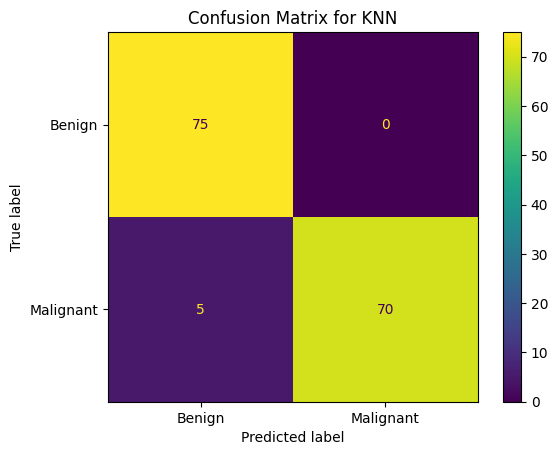

/home/mateo/cosas_de_clase/4/vpc/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(



----- Decision Tree -----


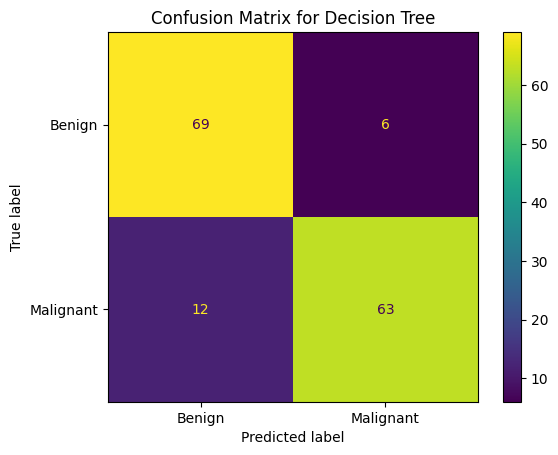


----- SVM -----


/home/mateo/cosas_de_clase/4/vpc/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


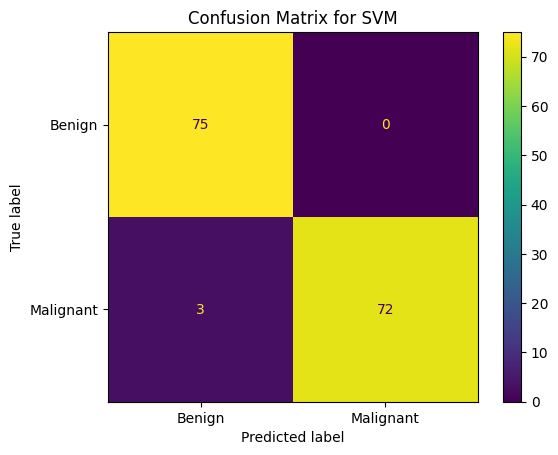


----- Best MLP -----


/home/mateo/cosas_de_clase/4/vpc/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


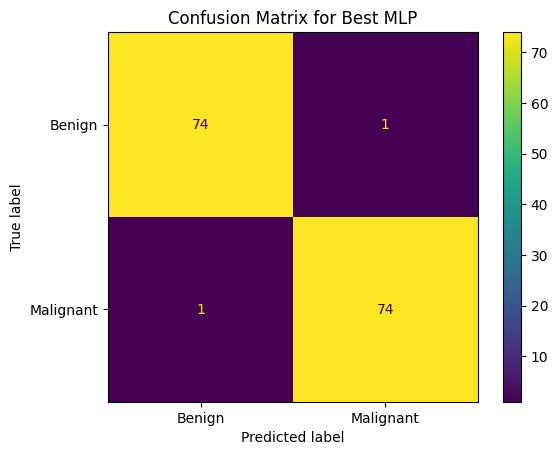


----- Comparación Final de Modelos en 'breast-cancer-test.csv' -----
               Accuracy  Balanced Accuracy  Cohen's Kappa
KNN              0.9667             0.9667         0.9333
Decision Tree    0.8800             0.8800         0.7600
SVM              0.9800             0.9800         0.9600
Best MLP         0.9867             0.9867         0.9733


In [18]:
# 1. Cargar y preparar el conjunto de datos de test final
test_final_df = pd.read_csv("breast-cancer-test.csv")
test_final_df.drop(columns=["id"], inplace=True)

X_final_test = test_final_df.drop(columns=["diagnosis"])
y_final_test = test_final_df["diagnosis"].map({"M": 1, "B": 0})

# Aplicar la transformación de escalado que fue MEJOR (usando el scaler ya ajustado)
if best_scaler == "MinMax":
    X_final_test_scaled = min_max_scaler.transform(X_final_test)
elif best_scaler == "Standard":
    X_final_test_scaled = standard_scaler.transform(X_final_test)
elif best_scaler == "Robust":
    X_final_test_scaled = robust_scaler.transform(X_final_test)
else: # Log
    X_final_test_scaled = X_final_test.apply(lambda x: np.log(x + 1))


# 2. Definir los modelos a comparar (con parámetros de ejemplo de prácticas anteriores)
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=SEMILLA),
    "SVM": SVC(kernel='rbf', C=1.0, random_state=SEMILLA),
    "Best MLP": best_mlp
}

# 3. Entrenar y evaluar cada modelo
final_results = {}
for name, model in models.items():
    # Entrenar el modelo con el conjunto de entrenamiento completo
    model.fit(best_X_train, y)
    
    # Realizar predicciones en el test final
    y_pred_final = model.predict(X_final_test_scaled)
    
    # Calcular métricas
    accuracy = accuracy_score(y_final_test, y_pred_final)
    balanced_acc = balanced_accuracy_score(y_final_test, y_pred_final)
    kappa = cohen_kappa_score(y_final_test, y_pred_final)
    final_results[name] = [accuracy, balanced_acc, kappa]
    
    # Mostrar matriz de confusión
    print(f"\n----- {name} -----")
    cm = confusion_matrix(y_final_test, y_pred_final)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
    disp.plot()
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

# 4. Mostrar tabla de resultados
results_df = pd.DataFrame(final_results, index=["Accuracy", "Balanced Accuracy", "Cohen's Kappa"]).T
print("\n----- Comparación Final de Modelos en 'breast-cancer-test.csv' -----")
print(results_df.round(4))

In [ ]:
y_pred = MLP.predict(X_test)